In [1]:
setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1002. Ecig Metabolomics NELF/P1002.3. Analyses/P1002.3.4. ML Visualizations/P1002.3.4.3. Confusion Matrix Figure/Input')
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1002. Ecig Metabolomics NELF/P1002.3. Analyses/P1002.3.4. ML Visualizations/P1002.3.4.3. Confusion Matrix Figure/Output')
cur_date = "050722"

library(readxl)
library(tidyverse)
library(ggrepel)
library(tidytext)
library(MetBrewer)

#reading in files
confusion_matrix_df_wo_covariates = data.frame(read_excel("030922_Smoking_Status_Prediction_Results.xlsx"))
confusion_matrix_df_w_covariates = data.frame(read_excel("050522_Smoking_Status_Prediction_Results_Covariates.xlsx"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
head(confusion_matrix_df_w_covariates)

,Model,Removed.Variables,Balanced.Accuracy,Sensitivity,Specificity,PPV,AUC
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,RF,None,0.9190476,0.8714286,0.9666667,0.9714286,0.9190476
2,RF,Nicotine & Cotinine,0.6809524,0.7619048,0.6000000,0.7033333,0.6809524
3,SVM,None,0.7752381,0.7904762,0.7600000,0.8300000,0.7752381
4,SVM,Nicotine & Cotinine,0.7752381,0.7904762,0.7600000,0.8300000,0.7752381
5,SVM+Var Selection,None,0.8785714,0.8571429,0.9000000,0.9214286,0.8785714
6,SVM+Var Selection,Nicotine & Cotinine,0.9157143,0.9380952,0.8933333,0.9250000,0.9157143


In [3]:
# creating a col that denotes whether or not covariates were included to combine into 1 df
confusion_matrix_df_w_covariates$Covariates = c(rep(c("Yes"), times = length(confusion_matrix_df_w_covariates$Model)))
confusion_matrix_df_wo_covariates$Covariates = c(rep(c("No"), times = length(confusion_matrix_df_wo_covariates$Model)))

# combining Model and Covariate cols
confusion_matrix_df = rbind(confusion_matrix_df_w_covariates, confusion_matrix_df_wo_covariates) %>%
    mutate(Covariates = ifelse(Covariates == "Yes", "Covariates", "")) %>%
    unite("Model", c("Model", "Covariates"), sep = "+",) %>%
    mutate(Removed.Variables = ifelse(Removed.Variables == "None", "All Predictors", "Removed Nicotine & Cotinine"),
        Model = ifelse(Model == "SVM+Var Selection+", "SVM+Var Selection",
                         ifelse(Model == "SVM+", "SVM",
                               ifelse(Model == "RF+", "RF", Model))))
    
head(confusion_matrix_df)

,Model,Removed.Variables,Balanced.Accuracy,Sensitivity,Specificity,PPV,AUC
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,RF+Covariates,All Predictors,0.9190476,0.8714286,0.9666667,0.9714286,0.9190476
2,RF+Covariates,Removed Nicotine & Cotinine,0.6809524,0.7619048,0.6000000,0.7033333,0.6809524
3,SVM+Covariates,All Predictors,0.7752381,0.7904762,0.7600000,0.8300000,0.7752381
4,SVM+Covariates,Removed Nicotine & Cotinine,0.7752381,0.7904762,0.7600000,0.8300000,0.7752381
5,SVM+Var Selection+Covariates,All Predictors,0.8785714,0.8571429,0.9000000,0.9214286,0.8785714
6,SVM+Var Selection+Covariates,Removed Nicotine & Cotinine,0.9157143,0.9380952,0.8933333,0.9250000,0.9157143


In [4]:
# creating a longer df for easier plotting
longer_confusion_matrix_df = confusion_matrix_df %>%
    pivot_longer(cols = 3:7, names_to = "Metric", values_to = "Value")

#putting into a factor to reorder
longer_confusion_matrix_df$Model = factor(longer_confusion_matrix_df$Model, levels = c( "RF", "RF+Covariates", "SVM",
                                                      "SVM+Covariates", "SVM+Var Selection", "SVM+Var Selection+Covariates"))
#putting metrics into a factor to reorder them by reverse alphabetical order
longer_confusion_matrix_df$Metric = factor(longer_confusion_matrix_df$Metric, levels = sort(unique(longer_confusion_matrix_df$Metric), decreasing = TRUE))
#longer_confusion_matrix_df$Removed.Variables = factor(longer_confusion_matrix_df$Removed.Variables, levels = c("Removed Nicotine & Cotinine", "All Predictors"))

head(longer_confusion_matrix_df)

Model,Removed.Variables,Metric,Value
<fct>,<chr>,<fct>,<dbl>
RF+Covariates,All Predictors,Balanced.Accuracy,0.9190476
RF+Covariates,All Predictors,Sensitivity,0.8714286
RF+Covariates,All Predictors,Specificity,0.9666667
RF+Covariates,All Predictors,PPV,0.9714286
RF+Covariates,All Predictors,AUC,0.9190476
RF+Covariates,Removed Nicotine & Cotinine,Balanced.Accuracy,0.6809524


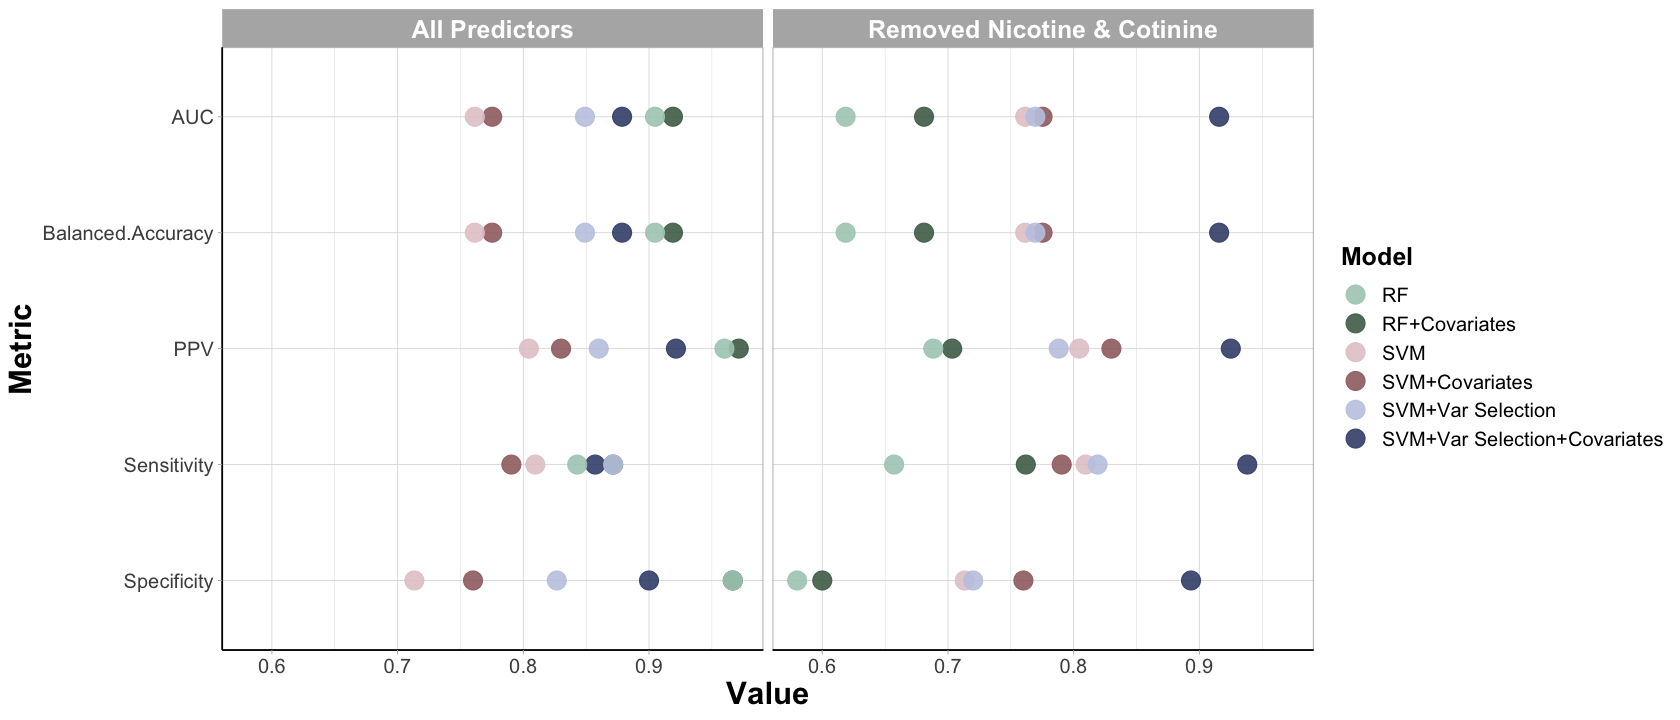

In [5]:
options(repr.plot.width=14, repr.plot.height=6) #changing size

#choosing palette from package
metbrewer_colors = MetPalettes$Monet[[1]]

FigureX = ggplot() + 
  geom_point(data = longer_confusion_matrix_df, aes(x = Value, y = Metric, color = Model), 
             size = 5, alpha = 0.9) +

  facet_wrap(~Removed.Variables) + 
  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  xlab('Value') + ylab('Metric') + #changing axis labels 

  scale_color_manual(name = "Model", values = metbrewer_colors[c(3,1,4,6,9,7)])

FigureX

In [6]:
#exporting figure
ggsave(FigureX, 
       filename = 'FigureX.pdf',
       path = Output,
       width = 14, height = 6)